In [ ]:
import numpy as np
from scipy.stats import kurtosis, skew
# import entropy as ent
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statistics as st
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
import pickle
from scipy.signal import butter, lfilter

import random
from scipy.fft import fft
import os
from sklearn.metrics import confusion_matrix
#feature selection variance based
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
#feature selection tree based
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from tensorflow.python import keras
import tensorflow as tf



In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
datasets_path = "/content/drive/MyDrive/CI_Dataset/"

Mounted at /content/drive


In [ ]:
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


In [ ]:
data_points_channel_1 = pickle.load(open(datasets_path + '/data_points_channel_1.pkl', 'rb'))
data_points_channel_2 = pickle.load(open(datasets_path + '/data_points_channel_2.pkl', 'rb'))
labels = pickle.load(open(datasets_path + '/labels.pkl', 'rb'))

sampling_freq = 256
#based on info from website

b, a = butter(3, [0.5, 40], btype='bandpass', fs=sampling_freq)

data_points_channel_1_filtered = np.array(
    [lfilter(b, a, data_points_channel_1[ind, :]) for ind in range(data_points_channel_1.shape[0])])
data_points_channel_2_filtered = np.array(
    [lfilter(b, a, data_points_channel_2[ind, :]) for ind in range(data_points_channel_2.shape[0])])

In [ ]:
data_points_channel_2_filtered.shape

(4000, 1280)

In [ ]:
data_points_channel_1_filtered.shape

(4000, 1280)

In [ ]:
def featured(x1):
    result = np.zeros((x1.shape[0], 15))
    for i in range(len(x1)):
        #statistical features
        result[i][0] = np.mean(x1[i])
        result[i][1] = np.var(x1[i])
        result[i][2] = np.std(x1[i])
        result[i][3] = skew(x1[i])
        result[i][4] = kurtosis(x1[i])
        result[i][5] = np.max(x1[i])
        result[i][6] = np.min(x1[i])
        result[i][7] = np.median(x1[i])
        result[i][8] = st.mode(x1[i])
        #time domain features
        result[i][9] = np.ptp(x1[i])
        result[i][10] = np.mean(np.absolute(x1[i] - np.mean(x1[i])))
        #frequency domain features
        ft = fft(x1[i])
        s = np.abs(ft ** 2) / x1.shape[0]
        result[i][11] = np.max(s)
        result[i][12] = np.sum(s)
        result[i][13] = np.mean(s)
        result[i][14] = np.var(s)

    return result


In [ ]:
def normalzie(data):
  x_normalized = np.zeros_like(data)
  scaler = MinMaxScaler()
  for i in range(data.shape[1]):
      x_normalized[:, i] = scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten()
  return x_normalized

In [ ]:
featured_data_ch1 = featured(data_points_channel_1_filtered)
featured_data_ch2 = featured(data_points_channel_2_filtered)
normal_featured_data_ch1 = normalzie(featured_data_ch1)
normal_featured_data_ch2 = normalzie(featured_data_ch2)

In [ ]:
normal_data_ch1 = normalzie(data_points_channel_1_filtered)
normal_data_ch2 = normalzie(data_points_channel_2_filtered)

In [ ]:
normal_featured_data_ch1.shape

(4000, 15)

In [ ]:
data_raw = []
data_raw.append([])
data_raw.append([])

data_raw[0] = normal_data_ch1
data_raw[1] = normal_data_ch2

data_raw = np.array(data_raw)
print(data_raw.shape)

(2, 4000, 1280)


In [ ]:
features_concat = np.concatenate((normal_featured_data_ch1, normal_featured_data_ch2), axis=0)
labels_cat = np.concatenate((labels, labels), axis=0)
labels_cat.shape

(8000,)

In [ ]:
target = data_raw.shape[1]
print(target)

4000


In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(features_concat, labels_cat)
clf.feature_importances_

model = SelectFromModel(clf, prefit=True)
data_featured = model.transform(features_concat)

feature_idx = model.get_support()
feature_indices = [index for index in range(len(feature_idx)) if feature_idx[index] == 1]

data_featured.shape

(8000, 6)

In [ ]:
print(feature_indices)

[2, 5, 9, 10, 12, 13]


In [ ]:
data_featured = np.concatenate((data_featured[:target], data_featured[target:]), axis=1)
data_featured.shape

(4000, 12)

In [ ]:
data_raw.shape

(2, 4000, 1280)

In [ ]:
x, y, z = data_raw.shape
data_raw_new = np.zeros((y, z, x))

for i in range(y):
    for j in range(z):
        for k in range(x):
            data_raw_new[i][j][k] = data_raw[k][i][j]


print(data_raw_new.shape)


(4000, 1280, 2)


In [ ]:
data_raw_new[0].shape

(1280, 2)

In [ ]:
data_featured.shape

(4000, 12)

In [ ]:
categorical_label=np.zeros((len(labels),2),int)
for i in range(labels.shape[0]):
    if labels[i]==0:
        categorical_label[i]=np.array((0,1),int)
    if labels[i]==1:
        categorical_label[i]=np.array((1,0),int)
print(categorical_label.shape)


(4000, 2)


In [ ]:
def data_split(data, label, feature):
    indices = np.arange(target)
    indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=seed)

    data_test = data[indices_test]
    label_test = label[indices_test]
    feature_test = feature[indices_test]

    indices_train_train, indices_train_val = train_test_split(indices_train, test_size=0.25, random_state=seed)

    data_train = data[indices_train_train]
    label_train = label[indices_train_train]
    feature_train = feature[indices_train_train]

    data_val = data[indices_train_val]
    label_val = label[indices_train_val]
    feature_val = feature[indices_train_val]

    return data_train, label_train, feature_train, data_test, label_test, feature_test, data_val, label_val, feature_val

In [ ]:
result = data_split(data_raw_new, categorical_label, data_featured)
data_points_train, labels_train, features_train, data_points_test, labels_test, features_test, data_points_val, labels_val, features_val = result

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Test Seizure

test_seizure_data_points_channel_1 = pickle.load(open(datasets_path + '/seizure_test_data_points_ch1.pkl', 'rb'))
test_seizure_data_points_channel_2 = pickle.load(open(datasets_path + '/seizure_test_data_points_ch2.pkl', 'rb'))

test_seizure_labels = np.ones(test_seizure_data_points_channel_1.shape[0])

sampling_freq = 256
#based on info from website

b, a = butter(3, [0.5, 40], btype='bandpass', fs=sampling_freq)

test_seizure_data_points_channel_1_filtered = np.array(
    [lfilter(b, a, test_seizure_data_points_channel_1[ind, :]) for ind in range(test_seizure_data_points_channel_1.shape[0])])
test_seizure_data_points_channel_2_filtered = np.array(
    [lfilter(b, a, test_seizure_data_points_channel_2[ind, :]) for ind in range(test_seizure_data_points_channel_2.shape[0])])

featured_test_seizure_data_ch1 = featured(test_seizure_data_points_channel_1_filtered)
featured_test_seizure_data_ch2 = featured(test_seizure_data_points_channel_2_filtered)
normal_featured_test_seizure_data_ch1 = normalzie(featured_test_seizure_data_ch1)
normal_featured_test_seizure_data_ch2 = normalzie(featured_test_seizure_data_ch2)

normal_test_seizure_data_ch1 = normalzie(test_seizure_data_points_channel_1_filtered)
normal_test_seizure_data_ch2 = normalzie(test_seizure_data_points_channel_2_filtered)

test_seizure_data_raw = []
test_seizure_data_raw.append([])
test_seizure_data_raw.append([])

test_seizure_data_raw[0] = normal_test_seizure_data_ch1
test_seizure_data_raw[1] = normal_test_seizure_data_ch2

test_seizure_data_raw = np.array(test_seizure_data_raw)

x, y, z = test_seizure_data_raw.shape
test_seizure_data_raw_new = np.zeros((y, z, x))

for i in range(y):
    for j in range(z):
        for k in range(x):
            test_seizure_data_raw_new[i][j][k] = test_seizure_data_raw[k][i][j]


test_seizure_features_concat = np.concatenate((featured_test_seizure_data_ch1, featured_test_seizure_data_ch2), axis=0)
test_seizure_labels_cat = np.concatenate((test_seizure_labels, test_seizure_labels), axis=0)

test_seizure_features = test_seizure_features_concat[:, feature_indices]

x = test_seizure_features.shape[0] // 2

test_seizure_features = np.concatenate((test_seizure_features[:x], test_seizure_features[x:]), axis=1)

categorical_test_seizure_label=np.zeros((len(test_seizure_labels),2),int)
for i in range(test_seizure_labels.shape[0]):
    if test_seizure_labels[i]==0:
        categorical_test_seizure_label[i]=np.array((0,1),int)
    if test_seizure_labels[i]==1:
        categorical_test_seizure_label[i]=np.array((1,0),int)

test_seizure_labels = categorical_test_seizure_label

print(test_seizure_features.shape,test_seizure_data_raw_new.shape,test_seizure_labels.shape)


(66, 12) (66, 1280, 2) (66, 2)


In [ ]:
test_plot=[]

In [ ]:
def cnn(filter1,filter2,kernel1,kernel2,dense1,dense2):
    input1 = tf.keras.Input(shape=data_raw_new[0].shape, name="first datas")
    input2 = tf.keras.Input(shape=data_featured[0].shape, name="featured datas")

    model1 = tf.keras.layers.Conv1D(filters=filter1, kernel_size=kernel1,strides=2, activation='relu',name='convolution_layer1')(input1)
    model1 = tf.keras.layers.MaxPool1D(pool_size=2,name='pooling_layer1')(model1)


    model1 = tf.keras.layers.Conv1D(filters=filter2, kernel_size=kernel2,strides=2, activation='relu',name='convolution_layer2')(model1)
    model1 = tf.keras.layers.MaxPool1D(pool_size=2,name='pooling_layer2')(model1)


    model1 = tf.keras.layers.Flatten(name='flatten_layer')(model1)

    model1 = tf.keras.layers.Dense(dense1, activation="relu",name='Dense_layer1')(model1)


    model1 = tf.keras.layers.Dense(dense2, activation="relu",name='Dense_layer_cnnfeatures')(model1)


    model2 = tf.keras.layers.Dense(data_featured.shape[1], activation="relu",name='Dense_layer_selectedfeature', trainable=False)(input2)

    concat = tf.keras.layers.Concatenate()([model1, model2])

    result = tf.keras.layers.Dense(2, activation="softmax",name='output_layer')(concat)

    model_final = tf.keras.Model([input1, input2], result)

    model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc",f1_m,precision_m, recall_m])
    res = model_final.fit([data_points_train, features_train], y=labels_train, batch_size=20, epochs=8,
                          validation_data=([data_points_val, features_val], labels_val))

    accuracy=res.history['acc']
    value_accuracy=res.history['val_acc']
    loss=res.history['loss']
    value_loss=res.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(value_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(value_loss, label='Validation Loss')
    plt.legend(loc='lower left')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


# test_seizure_features test_seizure_data_raw_new test_seizure_labels


    false_alarm=model_final.evaluate(x=[test_seizure_data_raw_new,test_seizure_features],y=test_seizure_labels,verbose=1)
    test_result= model_final.evaluate(x=[data_points_test,features_test],y=labels_test,verbose=0)

    print(test_result)
    print(false_alarm)

    y_prediction=model_final.predict([test_seizure_data_raw_new,test_seizure_features])
    y_prediction = np.argmax (y_prediction, axis = 1)
    y_test=np.argmax(test_seizure_labels, axis=1)

    #for test data
    y_prediction=model_final.predict([data_points_test,features_test])
    #Predict

    y_prediction = np.argmax (y_prediction, axis = 1)
    y_test=np.argmax(labels_test, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result_confusion = confusion_matrix(y_test, y_prediction , normalize='pred')
    print(result_confusion)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result_confusion, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    test_plot.append(test_result[1])

Epoch 1/8
120/120 [==============================] - 4s 25ms/step - loss: 0.6400 - acc: 0.6837 - f1_m: 0.6837 - precision_m: 0.6837 - recall_m: 0.6837 - val_loss: 0.6140 - val_acc: 0.7763 - val_f1_m: 0.7762 - val_precision_m: 0.7762 - val_recall_m: 0.7762
Epoch 2/8
120/120 [==============================] - 2s 17ms/step - loss: 0.5378 - acc: 0.7679 - f1_m: 0.7679 - precision_m: 0.7679 - recall_m: 0.7679 - val_loss: 0.4898 - val_acc: 0.8388 - val_f1_m: 0.8387 - val_precision_m: 0.8387 - val_recall_m: 0.8387
Epoch 3/8
120/120 [==============================] - 2s 16ms/step - loss: 0.4410 - acc: 0.8175 - f1_m: 0.8175 - precision_m: 0.8175 - recall_m: 0.8175 - val_loss: 0.4963 - val_acc: 0.8413 - val_f1_m: 0.8412 - val_precision_m: 0.8412 - val_recall_m: 0.8412
Epoch 4/8
120/120 [==============================] - 2s 17ms/step - loss: 0.4293 - acc: 0.8200 - f1_m: 0.8200 - precision_m: 0.8200 - recall_m: 0.8200 - val_loss: 0.4509 - val_acc: 0.8000 - val_f1_m: 0.8000 - val_precision_m: 0.8000

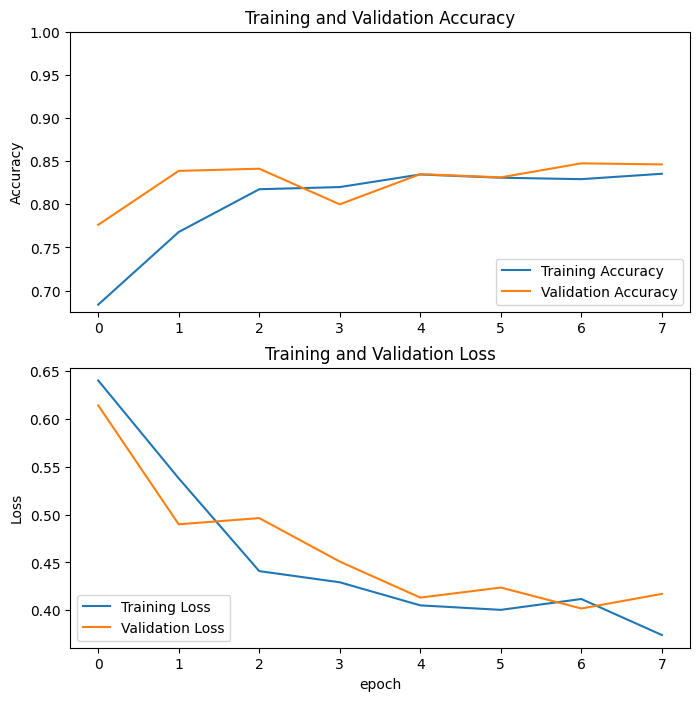

3/3 [==============================] - 0s 8ms/step - loss: 27877570.0000 - acc: 0.7879 - f1_m: 0.5417 - precision_m: 0.5417 - recall_m: 0.5417
[0.3936390280723572, 0.8424999713897705, 0.8424999117851257, 0.8424999713897705, 0.8424999713897705]
[27877570.0, 0.7878788113594055, 0.5416666865348816, 0.5416666865348816, 0.5416666865348816]
25/25 [==============================] - 0s 7ms/step
[[0.8321513  0.14588859]
 [0.1678487  0.85411141]]


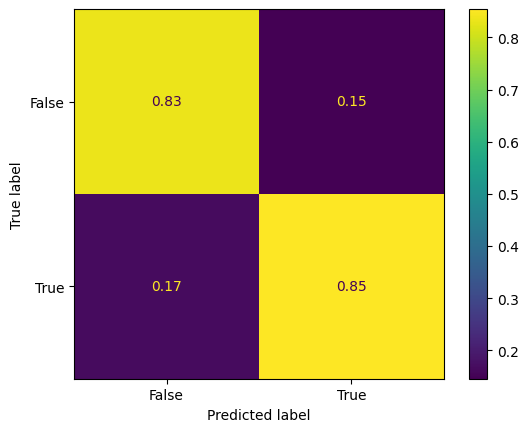

In [ ]:
cnn(60,60,4,4,100,20)
